In [166]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
import jobs

# standardize plot
def standardize(size=(10, 5)):
  plt.gcf().set_size_inches(*size)
  plt.grid(True)
  # set dpi
  plt.gcf().set_dpi(100)
  # set font
  plt.rcParams.update({'font.size': 12})

In [192]:
# read a log file
def read_logfile(logfile):
  with open(logfile, "rb") as f:
    logs = pickle.load(f)
  print(f"Reading from {logfile}")
  # print(f"logs.keys(): {logs.keys()}")
  # print(f"logs['solver_stats'].keys(): {logs['solver_stats'][0].keys()}")
  # extract stats
  data = {}
  data["num_vars"] = np.asarray([x['num_vars'] for x in logs['solver_stats']])
  data["solve_time_ms"] = np.asarray([x['solve_time_ms'] for x in logs['solver_stats']])
  data["setup_time_ms"] = np.asarray([x['setup_time_ms'] for x in logs['solver_stats']])
  data["obj_val"] = np.asarray([x['objective_val'] for x in logs['solver_stats']])
  data["times_min"] = np.asarray([x['time']/60 for x in logs['solver_stats']])
  data["num_jobs"] = np.asarray([x['num_jobs'] for x in logs['solver_stats']])
  return data

In [193]:
# read rtol=1e-2, 1e-3
data_1em2 = read_logfile("/home/sauce/data/solvers/logs/40k_logs.pkl")
data_1em3 = read_logfile("/home/sauce/data/solvers/logs/40k_logs_1e-3.pkl")

Reading from /home/sauce/data/solvers/logs/40k_logs.pkl
Reading from /home/sauce/data/solvers/logs/40k_logs_1e-3.pkl


In [181]:
# warm-start data
# data_1em2_warm_start = read_logfile("/home/sauce/data/solvers/logs/40k_logs_warm_start.pkl")
data_1em2_warm_start_10s = read_logfile("/home/sauce/data/solvers/logs/40k_logs_warm_start_10s.pkl")

Reading from /home/sauce/data/solvers/logs/40k_logs_warm_start_10s.pkl


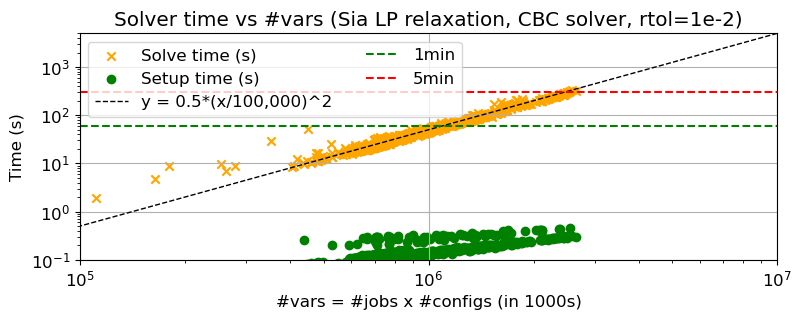

In [187]:
# scatter plot num_vars vs solve_time_ms
data = data_1em2
plt.scatter(data["num_vars"], data["solve_time_ms"]/1000, marker='x', color='orange', label="Solve time (s)")
plt.scatter(data["num_vars"], data["setup_time_ms"]/1000, marker='o', color='g', label="Setup time (s)")
plt.xlabel("#vars = #jobs x #configs (in 1000s)")
plt.ylabel("Time (s)")
plt.title("Solver time vs #vars (Sia LP relaxation, CBC solver, rtol=1e-2)")
standardize(size=(9, 3))
# plot a line: y = mx + c, m=0.01, c=70
x = np.linspace(1e4, 1e7, 20)
y = 0.5*((x/1e5)**2)
plt.plot(x, y, 'k--', linewidth=1, label="y = 0.5*(x/100,000)^2")
plt.yscale("log")
plt.xscale("log")
plt.xlim([1e5, 1e7])
plt.ylim([0.1, 5000])
# get axes
plt.axhline(60, color='g', linestyle='--', label='1min')
plt.axhline(300, color='r', linestyle='--', label='5min')
plt.legend(ncol=2)
plt.savefig("figs/cbc_rtol1e-2_num_vars_vs_solve_time.jpg", bbox_inches='tight', dpi=300)

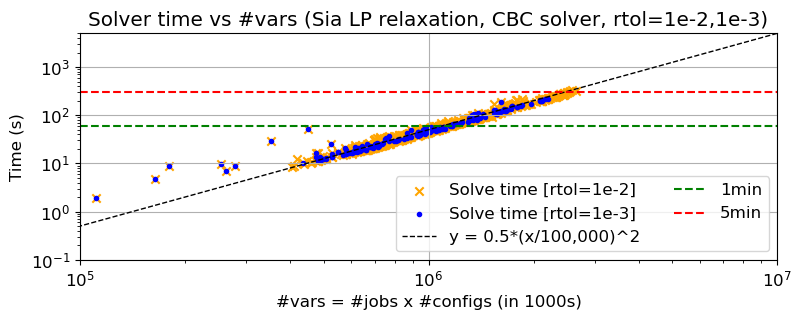

In [186]:
# scatter plot num_vars vs solve_time_ms for 1e-2, 1e-3
plt.scatter(data_1em2["num_vars"], data_1em2["solve_time_ms"]/1000, marker='x', color='orange', label="Solve time [rtol=1e-2]")
plt.scatter(data_1em3["num_vars"], data_1em3["solve_time_ms"]/1000, marker='.', color='blue', label="Solve time [rtol=1e-3]")
plt.xlabel("#vars = #jobs x #configs (in 1000s)")
plt.ylabel("Time (s)")
plt.title("Solver time vs #vars (Sia LP relaxation, CBC solver, rtol=1e-2,1e-3)")
standardize(size=(9, 3))
# plot a line: y = mx + c, m=0.01, c=70
x = np.linspace(1e4, 1e7, 20)
y = 0.5*((x/1e5)**2)
plt.plot(x, y, 'k--', linewidth=1, label="y = 0.5*(x/100,000)^2")
plt.yscale("log")
plt.xscale("log")
plt.xlim([1e5, 1e7])
plt.ylim([0.1, 5000])
# get axes
plt.axhline(60, color='g', linestyle='--', label='1min')
plt.axhline(300, color='r', linestyle='--', label='5min')
plt.legend(ncol=2)
plt.savefig("figs/cbc_rtol_comparison_num_vars_vs_solve_time.jpg", bbox_inches='tight', dpi=300)

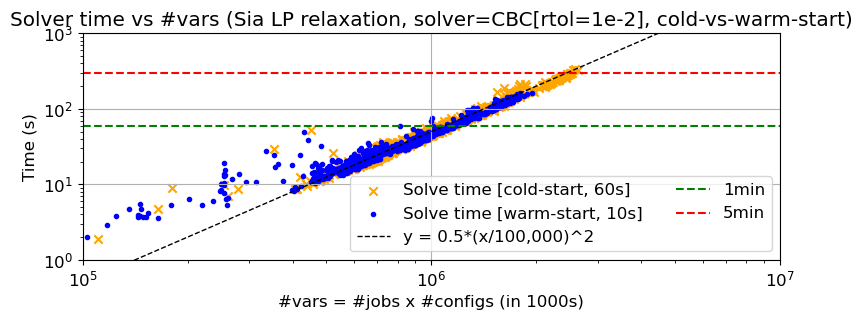

In [184]:
# scatter plot num_vars vs solve_time_ms for 1e-2, warm-start
plt.scatter(data_1em2["num_vars"], data_1em2["solve_time_ms"]/1000, marker='x', color='orange', label="Solve time [cold-start, 60s]")
data = data_1em2_warm_start_10s
plt.scatter(data["num_vars"], data["solve_time_ms"]/1000, marker='.', color='blue', label="Solve time [warm-start, 10s]")
plt.xlabel("#vars = #jobs x #configs (in 1000s)")
plt.ylabel("Time (s)")
plt.title("Solver time vs #vars (Sia LP relaxation, solver=CBC[rtol=1e-2], cold-vs-warm-start)")
standardize(size=(9, 3))
# plot a line: y = mx + c, m=0.01, c=70
x = np.linspace(1e4, 1e7, 20)
y = 0.5*((x/1e5)**2)
plt.plot(x, y, 'k--', linewidth=1, label="y = 0.5*(x/100,000)^2")
plt.yscale("log")
plt.xscale("log")
plt.xlim([1e5, 1e7])
plt.ylim([1, 1000])
# get axes
plt.axhline(60, color='g', linestyle='--', label='1min')
plt.axhline(300, color='r', linestyle='--', label='5min')
plt.legend(ncol=2)
plt.savefig("figs/cbc_warm-start_comparison_num_vars_vs_solve_time.jpg", bbox_inches='tight', dpi=300)

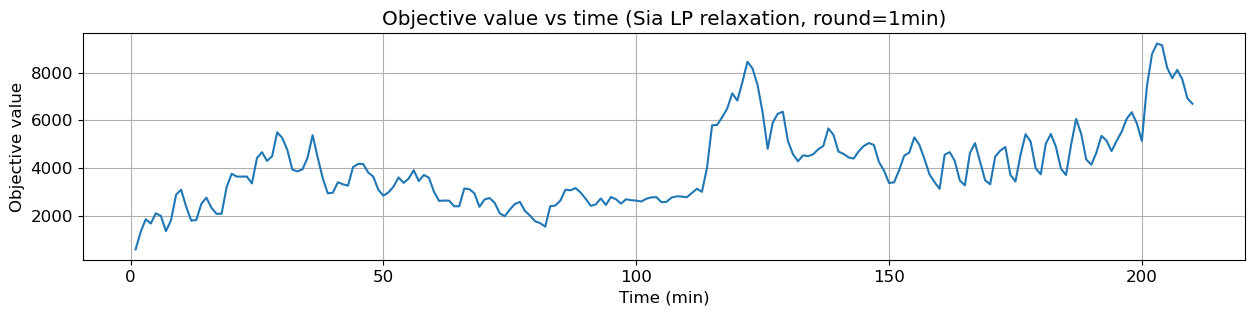

In [170]:
# plot objective value vs time
plt.plot(times_min, obj_val)
plt.xlabel("Time (min)")
plt.ylabel("Objective value")
plt.title("Objective value vs time (Sia LP relaxation, round=1min)")
standardize(size=(15, 3))
# plt.yscale("log")